In [1]:
import numpy as np
import math as math
import matplotlib.pyplot as plt

The resonant frequency of this system is: 0.5 Hz.
[1. 1. 1. ... 1. 1. 1.]


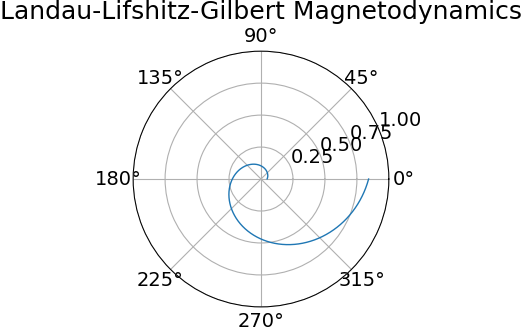

In [6]:
def rk4(x, t, tau, derivsRK, gamma, M_mag, H, theta, alpha):     #Garcia's rk4 function
    """
    Runge-Kutta integrator (4th order)
    Input arguments
    :param x: current value of dependent variable
    :param t: independent variable (usually time)
    :param tau: step size (usually time step)
    :param derivsRK: right hand side of the ODE; derivsRK is the name of the function which returns dx/dt
    Calling format derivsRK (x, t, param).
    :param param: estra parameters passed to derivsRK  GM in this case
    :return:
    xout: new value of x after a step of size tau
    """

    half_tau = 0.5*tau
    F1 = derivsRK(x, t, gamma, M_mag, H, theta, alpha)
    t_half = t + half_tau
    xtemp = x + half_tau*F1
    F2 = derivsRK(xtemp, t_half, gamma, M_mag, H, theta, alpha)
    xtemp = x + half_tau*F2
    F3 = derivsRK(xtemp, t_half, gamma, M_mag, H, theta, alpha)
    t_full = t + tau
    xtemp = x + tau*F3
    F4 = derivsRK(xtemp, t_full, gamma, M_mag, H, theta, alpha)
    xout = x + tau/6.0 * (F1 + F4 + 2.0*(F2+F3))

    return xout # magnetization vector

def LL_rk(s, t, gamma, M_mag, H, theta, alpha):       #Landau-Lifshitz Equation         
    """ 
    Returns the right-hand side of the Kepler ODE; used by Runge-Kutta routines
    :param s: State vector [r(0), r(1), r(2), v(0), v(1), v(2)]
    :param t: Time 
    :return: deriv: Derivatives [dr(0)/dt), dr(1)/dt, dr(2)/dt, dv(0)/dt, dv(1)/dt, dr(2)/dt]
    """

    # Compute dM/dt
    r = s[:3]  # Unravel the vector s into position and velocity
    v = s[3:]
    #accel = -GM * r / np.linalg.norm(r)**3  #Keplerian Gravitational acceleration
    torque = -gamma*np.cross(r, H)
    damping = -alpha*gamma/M_mag * np.cross(r, torque)
    
    # Return derivatives
    deriv = torque + damping   # dm/dt vector
    
    return deriv

def dinput(input_text) :           #text input functions
    return int(input(input_text))

def finput(input_text) :
    return float(input(input_text))

#Declare/Input physical paramters
M_mag =   1    # [Tesla]
theta_0 = 1    # [radians]
H_mag =   1    # [Tesla]
gamma = -0.5    # gyromagnetic ratio [radians/sec/Tesla]
alpha =   -1    # damping factor [dimensionless]


M_vector = np.array([M_mag*np.sin(theta_0), 0.0, M_mag*np.cos(theta_0)]) #initial magnetization vector
dM = np.array([0.0, 0.0, 0.0])      #needs to be edited
state = np.array([M_vector[0], M_vector[1], M_vector[2], dM[0], dM[1], dM[2]])
H_eff = np.array([0.0, 0.0, H_mag])
theta = theta_0

freq_res = -gamma*H_mag     #calculate Resonant frequency

# timestep parameters for for-loop
time = 0.0
dt = .005
nStep = 2500

# create data arrays
rplot = np.zeros(nStep)
phiplot = np.zeros(nStep)
tplot = np.zeros(nStep)
xplot = np.zeros(nStep)
yplot = np.zeros(nStep)
zplot = np.zeros(nStep)
magplot = np.zeros(nStep)

method = 0     #    0:rk4  or  1:Euler-cromer

#Recursively calculate M(t) using rk4
for iStep in range(nStep):

    # Record position and energy for plotting
    rplot[iStep] = np.sqrt(state[0]**2 + state[1]**2)  # Record radial position and angle for polar plot
    phiplot[iStep] = np.arctan2(state[1], state[0])
    tplot[iStep] = time
    theta = np.arctan2(state[2], np.sqrt(state[0]**2 + state[1]**2))
    xplot[iStep] = state[0]
    yplot[iStep] = state[1]
    zplot[iStep] = state[2]
    magplot[iStep] = np.sqrt(state[0]**2 + state[1]**2 + state[2]**2)
    
    if method == 0:
    # Calculate new position and velocity using the Runge-Kutta method
        state[:3] = rk4(state[:3], time, dt, LL_rk, gamma, M_mag, H_eff, theta, alpha) # m vector
        state[3:] = LL_rk(state, time, gamma, M_mag, H_eff, theta, alpha)              # dm/dt vector
        time += dt
    else:
    # Calculate new position and velocity using the Euler-Cromer method
        #state[:3] = rk4(state[:3], time, dt, LL_rk, gamma, M_mag, H_eff, theta, alpha) # m vector
        #state[3:] = LL_rk(state, time, gamma, M_mag, H_eff, theta, alpha)              # dm/dt vector
        time += dt    

# Polar Graph (xy-projection)
D = 1 #Sizing parameter
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phiplot, rplot)
ax.set_rmax(D)
ax.set_rticks([D/4, D/2, 3*D/4, D])
ax.set_title('Landau-Lifshitz-Gilbert Magnetodynamics')


print('The resonant frequency of this system is:', freq_res, 'Hz.')
print(magplot)


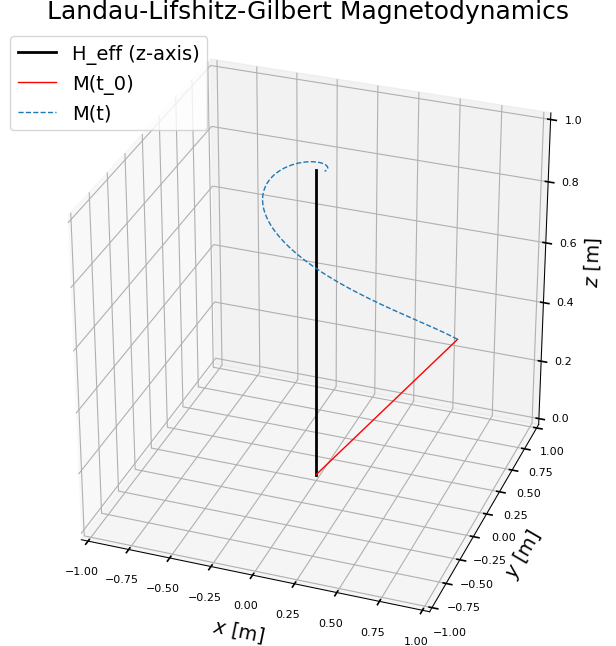

In [7]:
from mpl_toolkits import mplot3d

# Initial Mag Vector Position
initx = np.array([0, xplot[0]])
inity = np.array([0, yplot[0]])
initz = np.array([0, zplot[0]])

# H_eff / z-axis
axx = np.array([0, 0])
axy = np.array([0, 0])
axz = np.array([0, 1])

#3D plot of M(t)
fig1 = plt.figure(figsize=(8,8))
ax1 = plt.axes(projection='3d')
ax1.set_box_aspect((1,1,1))
ax1.plot3D(axx, axy, axz, c='k', lw=2, label='H_eff (z-axis)')
ax1.plot3D(initx, inity, initz, c='r', label='M(t_0)')
ax1.plot3D(xplot, yplot, zplot, ls='--', label='M(t)')
ax1.view_init(30,-70) # tilt, rotate angles
ax1.set_xlabel('$x$ [m]')
ax1.set_ylabel('$y$ [m]')
ax1.set_zlabel('$z$ [m]')
ax1.set_xlim(-1,1)
ax1.set_ylim(-1,1)
ax1.set_zlim(0,1)
ax1.set_title('Landau-Lifshitz-Gilbert Magnetodynamics')
ax1.tick_params('both', length=10, width=1.2, which='major',labelsize=8)
ax1.legend(loc='upper left')

plt.show()

1.9608366252670855
Fit Amplitude = 0.806
Fit Decay Rate = 0.1819


Text(0, 0.5, 'r(t) [m]')

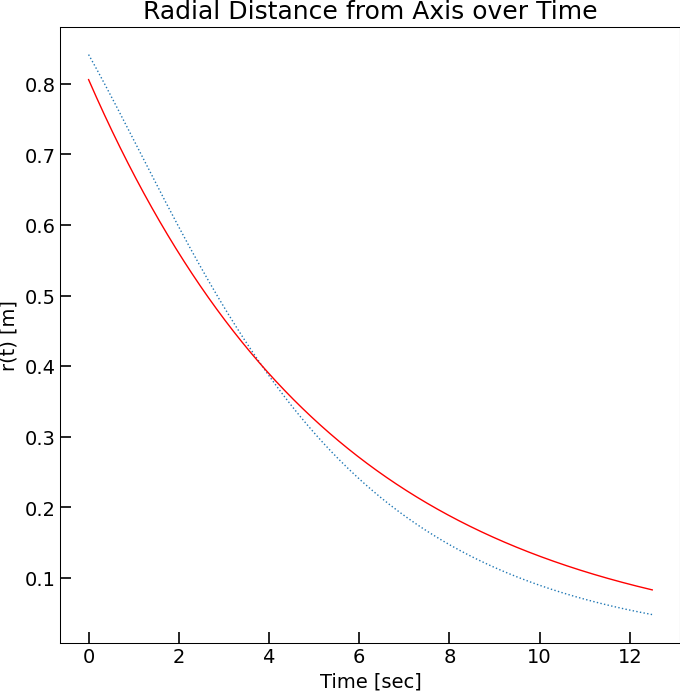

In [8]:
amp = 0.800
w = 0.1800
rows = 200
cols = 200
lsq = [[0 for j in range(cols)] for i in range(rows)] #2d array for least squares fit

for g in range (200):
    for h in range (200):
        expfit = amp*np.exp(-w*tplot)
        lsq[g][h] = sum((expfit - rplot)**2)
        w += h * 0.0001
    w = 0.1800
    amp += g * 0.001
        
print(min(min(lsq)))
for g in range (200):
    for h in range (200):
        if lsq[g][h] == min(min(lsq)):
            A = 0.8 + g*0.001
            omega = w + h*0.0001
            print('Fit Amplitude =', A)
            print('Fit Decay Rate =', omega)

fit = A*np.exp(-omega*tplot)            

fig2 = plt.figure(figsize=(8,8))
plt.plot(tplot, rplot, ls='dotted', label='Data Points')
plt.plot(tplot, fit, c='r', label='Fit Line')
#plt.plot(tplot, 1/((1/max(rplot))+tplot), c='g')
plt.title('Radial Distance from Axis over Time')
plt.xlabel('Time [sec]')
plt.ylabel('r(t) [m]')